# The Quantum Ising Chain
### Carsten Bauer, Katharine Hyatt

## Introduction

In this tutorial we will consider a simple quantum mechanical system of spins sitting on a chain. Here, *quantum mechanical*, despite its pompous sound, simply means that our Hamiltonian matrix will have a non-trivial (i.e. non-diagonal) matrix structure.

We will then ask a couple of basic questions,

* What is the ground state of the system?
* What happens if we turn on a transverse magnetic field?
* Are there any phase transitions?

To get answers to the questions, we will solve the time-independent Schrödinger equation

$$H|\psi\rangle = E |\psi\rangle$$

in Julia by means of exact diagonalization of the Hamiltonian.

## Transverse field quantum Ising chain

Let's start out by defining our system. The Hamiltonian is given by

$$\mathcal{H} = -\sum_{\langle i, j \rangle} \hat{\sigma}_i^z \otimes \hat{\sigma}_j^z - h\sum_i \hat{\sigma}_i^x$$

Here, $\hat{\sigma}^z$ and $\hat{\sigma}^x$ are two of the three [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices), representing our quantum spins, $\langle i, j \rangle$ indicates that only neighboring spins talk to each other, and $h$ is the amplitude of the magnetic field.

The idea behind this Hamiltonian is as follows:

* The first term is diagonal in the $\sigma^z$ eigenbasis. If there is no magnetic field, $h=0$, our quantum model reduces to the well-known classical [Ising model](https://en.wikipedia.org/wiki/Ising_model) (diagonal = trivial matrix structure -> classical). In this case, we have a **finite temperature phase transition** from a paramagnetic ($T>T_c$) phase, where the spins are **disordered by thermal fluctuations**, to a ferromagnetic phase ($T<T_c$), where they all point into the $z$ direction and, consequently, a ferromagnetic ground state at $T=0$.

* Since this would be boring, we want to add quantum complications to this picture by making $H$ non-diagonal. To this end, we couple a transverse magnetic field $h$ to the $x$ component of our quantum spins in the second term. Now, since $\sigma^z$ and $\sigma^x$ do not commute, there is no common eigenbasis of the first and the second term and our Hamiltonian has a non-trivial matrix structure (It's quantum!). If there was *only the second term* the system would, again, be trivial, as it would be diagonal in the eigenbasis of $\sigma^x$: the spins want to align to the magnetic field and point in $x$ direction.

* We can see that if we have both terms we have a competition between the spins wanting to point in the $z$ direction (first term) and at the same time wanting to align to the magnetic field in $x$ direction. One says that the magnetic field term adds **quantum fluctuations** to the system.

Let us explore what the effect of those quantum fluctuations on the ground state is!

## Building the Hamiltonian matrix

First we need our building blocks, the Pauli matrices. We will choose the $\sigma^z$ eigenbasis as our computation basis in which they take the following form.

In [42]:
σᶻ = [1 0; 0 -1] # \sigma <TAB> followed by \^z <TAB>

2×2 Array{Int64,2}:
 1   0
 0  -1

In [43]:
σˣ = [0 1; 1 0]

2×2 Array{Int64,2}:
 0  1
 1  0

Labeling the eigensates of $\sigma^z$ as $|\downarrow\rangle$ and $|\uparrow\rangle$ the effect of the pauli matrices on these basis states is:
$$\hat{\sigma}^z\left| \downarrow \right\rangle = \left| \downarrow \right\rangle$$

$$\hat{\sigma}^z\left| \uparrow \right\rangle = \left| \uparrow \right\rangle$$

$$\hat{\sigma}^x\left| \downarrow \right\rangle = \left| \uparrow \right\rangle$$

$$\hat{\sigma}^x\left| \uparrow \right\rangle = \left| \downarrow \right\rangle$$

Clearly, $\sigma^x$, since being purely off-diagonal, flips our $z$ spin states. In Julia:

In [46]:
σˣ * [1,0]

2-element Array{Int64,1}:
 0
 1

In [47]:
σˣ * [0,1]

2-element Array{Int64,1}:
 1
 0

To build up our Hamiltonian matrix we need to take the kronecker product (tensor product) of spin matrices. Fortunately, Julia has a built-in function for this.

In [48]:
kron(σᶻ,σᶻ) # this is the matrix of the tensor product σᶻᵢ⊗ σᶻⱼ (⊗ = \otimes <TAB>)

4×4 Array{Int64,2}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

Let's be fancy (cause we can!) and make this look a bit cooler.

In [49]:
⊗(x,y) = kron(x,y)

⊗ (generic function with 1 method)

In [50]:
σᶻ ⊗ σᶻ

4×4 Array{Int64,2}:
 1   0   0  0
 0  -1   0  0
 0   0  -1  0
 0   0   0  1

(How cool is that?)

### Explicit 4-site Hamiltonian

Imagine our spin chain consists of four sites. Writing out identity matrices (which were left implicit in $H$ above) explicitly, our Hamiltonian reads

$$\mathcal{H}_4 = -\hat{\sigma}_1^z \hat{\sigma}_2^z \hat{I}_3 \hat{I}_4 - \hat{I}_1 \hat{\sigma}_2^z \hat{\sigma}_3^z \hat{I}_4 - \hat{I}_1 \hat{I}_2 \hat{\sigma}_3^z \hat{\sigma}_4^z - \hat{\sigma}^z_1 \hat{I}_2 \hat{I}_3 \hat{\sigma}_4^z - h\left(\hat{\sigma}_1^x\hat{I}_2 \hat{I}_3\hat{I}_4 + \hat{I}_1 \hat{\sigma}_2^x \hat{I}_3\hat{I}_4 +\hat{I}_1 \hat{I}_2 \hat{\sigma}_3^x\hat{I}_4 + \hat{I}_1 \hat{I}_2 \hat{I}_3 \hat{\sigma}_4^x\right)$$

Translating this expression to Julia is super easy. After defining the identity matrix

In [51]:
id = [1 0; 0 1] # identity matrix

2×2 Array{Int64,2}:
 1  0
 0  1

we can simply write

In [52]:
h = 2
H = - σᶻ⊗σᶻ⊗id⊗id - id⊗σᶻ⊗σᶻ⊗id - id⊗id⊗σᶻ⊗σᶻ
H -= h*(σˣ⊗id⊗id⊗id + id⊗σˣ⊗id⊗id + id⊗id⊗σˣ⊗id)

16×16 Array{Int64,2}:
 -3   0  -2   0  -2   0   0   0  -2   0   0   0   0   0   0   0
  0  -1   0  -2   0  -2   0   0   0  -2   0   0   0   0   0   0
 -2   0   1   0   0   0  -2   0   0   0  -2   0   0   0   0   0
  0  -2   0  -1   0   0   0  -2   0   0   0  -2   0   0   0   0
 -2   0   0   0   1   0  -2   0   0   0   0   0  -2   0   0   0
  0  -2   0   0   0   3   0  -2   0   0   0   0   0  -2   0   0
  0   0  -2   0  -2   0   1   0   0   0   0   0   0   0  -2   0
  0   0   0  -2   0  -2   0  -1   0   0   0   0   0   0   0  -2
 -2   0   0   0   0   0   0   0  -1   0  -2   0  -2   0   0   0
  0  -2   0   0   0   0   0   0   0   1   0  -2   0  -2   0   0
  0   0  -2   0   0   0   0   0  -2   0   3   0   0   0  -2   0
  0   0   0  -2   0   0   0   0   0  -2   0   1   0   0   0  -2
  0   0   0   0  -2   0   0   0  -2   0   0   0  -1   0  -2   0
  0   0   0   0   0  -2   0   0   0  -2   0   0   0   1   0  -2
  0   0   0   0   0   0  -2   0   0   0  -2   0  -2   0  -1   0
  0   0   0   0   

There it is.

Even though defining the Hamiltonian via tensor products is really cool, we certainly wouldn't want to write out all the terms for, say, 100 sites explicitly. Instead it's more efficient to construct a basis for the many-spin Hilbert space and calculate the matrix elements of the Hamiltonian iteratively.

### Basis representation

Beyond a single spin, we have to think how to encode our basis states.

We make the arbitrary choice:
$0 = \text{false} = \downarrow$ and $1 = \text{true} = \uparrow$

This way, our many-spin basis states have nice binary representations.

Example: $|0010\rangle = |\text{false},\text{false},\text{true},\text{false}\rangle = |\downarrow\downarrow\uparrow\downarrow>$ is a basis state of a 4-site system

We construct the full basis by binary counting.

In [61]:
bit_rep(num::Integer, N::Integer) = BitArray(parse(Bool, i) for i in string(num, base=2, pad=N))

"""
    generate_basis(N::Integer) -> basis

Generates a basis (`Vector{BitArray}`) spanning the Hilbert space of `N` spins.
"""
function generate_basis(N::Integer)
    nstates = 2^N
    basis = Vector{BitArray{1}}(undef, nstates)
    for i in 0:nstates-1
        basis[i+1] = bit_rep(i, N)
    end
    return basis
end

generate_basis

In [65]:
generate_basis(4) .|> x->convert(Vector{Int}, x)

16-element Array{Array{Int64,1},1}:
 [0, 0, 0, 0]
 [0, 0, 0, 1]
 [0, 0, 1, 0]
 [0, 0, 1, 1]
 [0, 1, 0, 0]
 [0, 1, 0, 1]
 [0, 1, 1, 0]
 [0, 1, 1, 1]
 [1, 0, 0, 0]
 [1, 0, 0, 1]
 [1, 0, 1, 0]
 [1, 0, 1, 1]
 [1, 1, 0, 0]
 [1, 1, 0, 1]
 [1, 1, 1, 0]
 [1, 1, 1, 1]

### Iterative construction of $H$

Equipped with our basis, we can construct the matrix elements of our Hamiltonian, $\langle \psi_1 | H | \psi_2 \rangle$, by applying $H$ to our basis states and utilizing their orthonormality, $\langle \psi_i | \psi_j \rangle = \sigma_{i,j}$.

In [70]:
using LinearAlgebra

function TransverseFieldIsing(; N::Integer, h::T=0) where T<:Real
    basis = generate_basis(N)
    H = zeros(T, 2^N, 2^N)
    bonds = zip(collect(1:N-1), collect(2:N))
    for (i, bstate) in enumerate(basis)
        # diagonal part
        diag_term = 0.
        for (site_i, site_j) in bonds
            diag_term -= !xor(bstate[site_i], bstate[site_j]) # xor = are they different
        end
        H[i, i] = diag_term
        
        # off diagonal part
        for site in 1:N
            new_bstate = copy(bstate)
            # flip the bit on the site (that's what σˣ does)
            new_bstate[site] ⊻= true
            new_i = findfirst(isequal(new_bstate), basis)
            H[i, new_i] = -h
        end
    end
    return Hermitian(H), basis
end

TransverseFieldIsing (generic function with 3 methods)

In [149]:
H, basis = TransverseFieldIsing(N=4, h=1)
H

16×16 Hermitian{Int64,Array{Int64,2}}:
 -3  -1  -1   0  -1   0   0   0  -1   0   0   0   0   0   0   0
 -1  -2   0  -1   0  -1   0   0   0  -1   0   0   0   0   0   0
 -1   0  -1  -1   0   0  -1   0   0   0  -1   0   0   0   0   0
  0  -1  -1  -2   0   0   0  -1   0   0   0  -1   0   0   0   0
 -1   0   0   0  -1  -1  -1   0   0   0   0   0  -1   0   0   0
  0  -1   0   0  -1   0   0  -1   0   0   0   0   0  -1   0   0
  0   0  -1   0  -1   0  -1  -1   0   0   0   0   0   0  -1   0
  0   0   0  -1   0  -1  -1  -2   0   0   0   0   0   0   0  -1
 -1   0   0   0   0   0   0   0  -2  -1  -1   0  -1   0   0   0
  0  -1   0   0   0   0   0   0  -1  -1   0  -1   0  -1   0   0
  0   0  -1   0   0   0   0   0  -1   0   0  -1   0   0  -1   0
  0   0   0  -1   0   0   0   0   0  -1  -1  -1   0   0   0  -1
  0   0   0   0  -1   0   0   0  -1   0   0   0  -2  -1  -1   0
  0   0   0   0   0  -1   0   0   0  -1   0   0  -1  -1   0  -1
  0   0   0   0   0   0  -1   0   0   0  -1   0  -1   0  -2  -1
 

Note that we tag the Hamiltonian as hermitian in `TransverseFieldIsing` through its type.

In [152]:
typeof(H)

Hermitian{Int64,Array{Int64,2}}

### Full exact diagonalization

Alright. Let's solve the Schrödinger equation by diagonalizing $H$ for a system with $N=8$ and $h=1$.

In [154]:
H, basis = TransverseFieldIsing(N=8, h=1)
vals, vecs = eigen(H)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
256-element Array{Float64,1}:
 -11.942570746604087 
 -10.847447176662078 
 -10.598240862393025 
 -10.26855224563388  
  -9.921019009586722 
  -9.596781441951794 
  -9.503117292451002 
  -9.322258155472806 
  -9.173428675691873 
  -9.114931375564518 
  -8.986194212359717 
  -8.92422236142283  
  -8.825895439644704 
   ⋮                 
   1.9242223614228289
   1.9861942123597043
   2.1149313755645065
   2.1734286756918615
   2.3222581554727975
   2.503117292451003 
   2.596781441951791 
   2.921019009586721 
   3.2685522456338845
   3.5982408623930255
   3.8474471766620644
   4.942570746604084 
eigenvectors:
256×256 Array{Float64,2}:
 -0.14882     0.301595    2.70617e-16  …   0.0          -0.0253217
 -0.111622    0.196129    0.060984        -0.00999493    0.0316533
 -0.0872134   0.138552    0.0634853        0.0203055     0.0405503
 -0.10699     0.137069    0.143095        -0.00649975   -0.0308588
 -0.0847267   0.1254

That's it. Here is our groundstate. 

In [155]:
groundstate = vecs[:,1];

The absolute square of this wave function is the probability of finding the system in a particular basis state.

In [156]:
abs2.(groundstate)

256-element Array{Float64,1}:
 0.022147421001740514 
 0.012459494900154439 
 0.007606182658957387 
 0.011446873256251858 
 0.007178621211962501 
 0.00453772614404195  
 0.006560990267446685 
 0.011209525890733693 
 0.0070921061191227845
 0.004091357184342536 
 0.0027310968733306466
 0.00424836707156307  
 0.006087381560493377 
 ⋮                    
 0.004248367071563103 
 0.0027310968733307295
 0.004091357184342661 
 0.007092106119123002 
 0.011209525890733717 
 0.006560990267446851 
 0.0045377261440421035
 0.007178621211962706 
 0.011446873256251933 
 0.007606182658957586 
 0.012459494900154829 
 0.02214742100174061  

It's instructive to look at the extremal cases $h=0$ and $h>>1$.

In [158]:
H, basis = TransverseFieldIsing(N=8, h=0)
vals, vecs = eigen(H)
abs2.(vecs[:,1])

256-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

As we can see, for $h=0$ the system is (with probability one) in the first basis state, where all spins point in $-z$ direction.

In [160]:
basis[1]

8-element BitArray{1}:
 false
 false
 false
 false
 false
 false
 false
 false

On the other hand, for $h=100$, the system occupies all basis states with approximately equal probability (maximal superposition) - corresponding to eigenstates of $\sigma^x$, i.e. alignment to the magnetic field.

In [161]:
H, basis = TransverseFieldIsing(N=8, h=100)
vals, vecs = eigen(H)
abs2.(vecs[:,1])

256-element Array{Float64,1}:
 0.003975198684172922 
 0.003955347535743809 
 0.003935620178145606 
 0.003955322752903304 
 0.003935595580712048 
 0.003915991149634061 
 0.0039355709214763486
 0.003955322690946298 
 0.003935595519257762 
 0.003915942261353096 
 0.003896460021706851 
 0.003915966674689176 
 0.00393554626274301  
 ⋮                    
 0.0039159666746892   
 0.0038964600217069258
 0.003915942261353158 
 0.003935595519257843 
 0.003955322690946323 
 0.003935570921476435 
 0.003915991149634129 
 0.0039355955807121555
 0.00395532275290336  
 0.0039356201781457255
 0.003955347535743876 
 0.003975198684172948 

# Magnetization

Let's vary $h$ and see what happens. Since we're looking at quantum magnets we will compute the overall magnetization, defined by

$$M = \frac{1}{N}\sum_{i} \sigma^z_i$$
where $\sigma^z_i$ is the value of the spin on site $i$ when we measure.

In [162]:
function magnetization(state, basis)
    M = 0.
    for (i, bstate) in enumerate(basis)
        bstate_M = 0.
        for spin in bstate
            bstate_M += (state[i]^2 * (spin ? 1 : -1))/length(bstate)
        end
        @assert abs(bstate_M) <= 1
        M += abs(bstate_M)
    end
    return M
end

magnetization (generic function with 1 method)

In [163]:
magnetization(groundstate, basis)

0.3661368654542446

Now we would like to examine the effects of $h$. We will:

1. Find a variety of $h$ to look at.
2. For each, compute the lowest energy eigenvector (groundstate) of the corresponding Hamiltonian.
3. For each groundstate, compute the overall magnetization $M$.
4. Plot $M(h)$ for a variety of system sizes, and see if anything cool happens.

[0.9996, 0.996931, 0.977618, 0.87876, 0.692449, 0.574108, 0.526891, 0.509676, 0.503478, 0.50125]
[0.999845, 0.998738, 0.988945, 0.905212, 0.673904, 0.555449, 0.518677, 0.506546, 0.502331, 0.500835]
[0.999875, 0.999023, 0.991945, 0.917586, 0.591575, 0.437996, 0.395981, 0.382355, 0.377621, 0.375939]
[0.99989, 0.999146, 0.993221, 0.933149, 0.576326, 0.427273, 0.391981, 0.380908, 0.3771, 0.375752]
[0.9999, 0.999224, 0.993893, 0.942106, 0.531264, 0.366666, 0.330129, 0.318646, 0.314686, 0.313283]
[0.999907, 0.99928, 0.994341, 0.948502, 0.518565, 0.359841, 0.327708, 0.31778, 0.314375, 0.313171]
[0.999912, 0.999321, 0.994672, 0.952577, 0.487899, 0.321452, 0.288917, 0.278821, 0.275351, 0.274123]
[0.999917, 0.999354, 0.994927, 0.955496, 0.47711, 0.316678, 0.287257, 0.278231, 0.275139, 0.274047]
[0.99992, 0.999379, 0.995132, 0.957622, 0.454014, 0.289611, 0.260052, 0.250942, 0.247816, 0.24671]


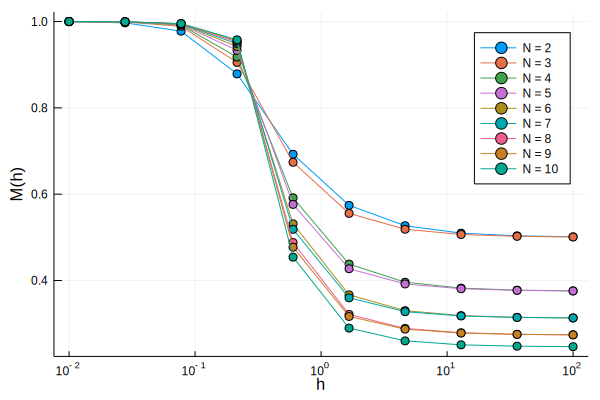

In [164]:
using Plots
hs = 10 .^ range(-2., stop=2., length=10)
Ns = 2:10
p = plot()
for N in Ns
    M = zeros(length(hs))
    for (i,h) in enumerate(hs)
        H, basis = TransverseFieldIsing(N=N, h=h)
        vals, vecs = eigen(H)
        groundstate = vecs[:,1]
        M[i] = magnetization(groundstate, basis)
    end
    plot!(p, hs, M, xscale=:log10, marker=:circle, label="N = $N",
        xlab="h", ylab="M(h)")
    println(M)
end
p

**This looks like a phase transition!**

For small $h$, the magnetization is unity, corresponding to a ferromagnetic state.

By increasing $h$ enhance quantum fluctuations which drive a phase transition to a **quantum paramagnetic** phase with $M\approx0$. (This is to be compared to increasing temperature in the classical Ising model, where thermal fluctuations cause a **classical paramagnetic** state.)

## TODO: Going to large $N$ - utilizing sparsity